In [1]:
import sys
from pathlib import Path

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")

import folium
from folium.plugins import HeatMap
from IPython.display import IFrame
reports_path = Path.cwd().parent / "reports"

sys.path.append(str(Path().resolve().parent / "src"))
from utils import load_all_csvs
from sanitize import sanitize_all
from aggregations import (
    exam_volume_by_zip,
    avg_cost_by_zip,
    exam_volume_by_age_group,
    top_coditems,
    add_age_column
)
from viz_aggregations import (
    plot_exam_volume_by_zip,
    plot_avg_cost_by_zip,
    plot_exam_volume_by_age_group,
    plot_top_coditems
)
from viz_map import generate_exam_location_map

In [2]:
dfs = load_all_csvs(Path.cwd().parent / "data")
dfs = sanitize_all(dfs)

In [3]:
dfs['geocode'].head()

,Unnamed: 0,Lab Id,Address,Location,Zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469


In [4]:
dfs['demographic'].head()

,Unnamed: 0,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
0,0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5
1,1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0
2,2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2
3,3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7
4,4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6


In [5]:
dfs['transactional'].head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,10.0


# 📘 H1 – Potencial Econômico e Demográfico

## Hipóteses:

- **H1a**: ZCTAs com maior densidade populacional têm maior volume de exames realizados  
- **H1b**: ZCTAs com maior renda média têm maior gasto médio por paciente  
- **H1c**: ZCTAs com maior proporção de população idosa (>65 anos) têm maior frequência de utilização dos serviços laboratoriais


## 📊 H1a: Densidade populacional vs. volume de exames

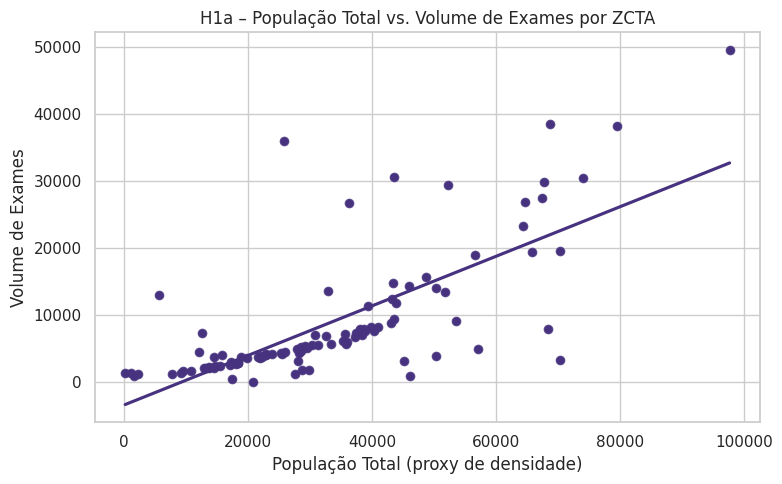

Correlação: 0.73


In [10]:
if 'ZCTA' not in dfs['transactional'].columns:
    dfs['geocode']['Zipcode'] = dfs['geocode']['Zipcode'].astype(str).str.zfill(5)
    # Adiciona a coluna ZCTA à tabela transacional
    dfs['transactional'] = dfs['transactional'].merge(
        dfs['geocode'][['Lab Id', 'Zipcode']],
        on='Lab Id',
        how='left'
    )
    # Renomeia para ZCTA se desejar unificar
    dfs['transactional'].rename(columns={'Zipcode': 'ZCTA'}, inplace=True)

if 'ZCTA' not in dfs['demographic'].columns:
    dfs['demographic']['ZCTA'] = dfs['demographic']['GeographicAreaName'].str.extract(r'ZCTA5 (\d{5})')[0]

# Padroniza como string para evitar erros de tipo
#dfs['transactional']['ZCTA'] = dfs['transactional']['ZCTA'].astype(str).str.zfill(5)
#dfs['demographic']['ZCTA'] = dfs['demographic']['ZCTA'].astype(str).str.zfill(5)

# Contagem de exames por ZCTA
df_exames_por_zcta = dfs['transactional'].groupby('ZCTA').size().reset_index(name='num_exames')

# Merge com dados demográficos
h1a_df = dfs['demographic'].merge(df_exames_por_zcta, on='ZCTA', how='inner')

# Estimar densidade populacional (sem área real, usar como proxy apenas população bruta)
# Obs: pode ser refinado com área do shapefile futuramente

# Visualização
plt.figure(figsize=(8,5))
sns.scatterplot(data=h1a_df, x='TotalPopulation', y='num_exames')
sns.regplot(data=h1a_df, x='TotalPopulation', y='num_exames', scatter=True, ci=None)
plt.title('H1a – População Total vs. Volume de Exames por ZCTA')
plt.xlabel('População Total (proxy de densidade)')
plt.ylabel('Volume de Exames')
plt.tight_layout()
plt.show()

corr = h1a_df[['TotalPopulation', 'num_exames']].corr().iloc[0,1]
print(f"Correlação: {corr:.2f}")

## 📊 Conclusões – H1a: População Total vs. Volume de Exames
- Existe uma correlação positiva moderada a forte entre a população total dos ZCTAs e o volume de exames realizados (r = 0.73).

- ZCTAs mais populosos tendem a apresentar maior volume de exames, apoiando a hipótese H1a.

- A distribuição, porém, é bastante dispersa, indicando que outros fatores também influenciam fortemente a demanda por exames — como presença de múltiplos laboratórios, perfil etário, ou condições socioeconômicas.

- Foram observados outliers com volume de exames muito alto para populações medianas, o que pode indicar polos regionais de atendimento. Como visto anteriormente a presença massiva de laborat[orios nessas regiões.

## 📊 H1b: ZCTAs com maior renda média têm maior gasto médio por paciente

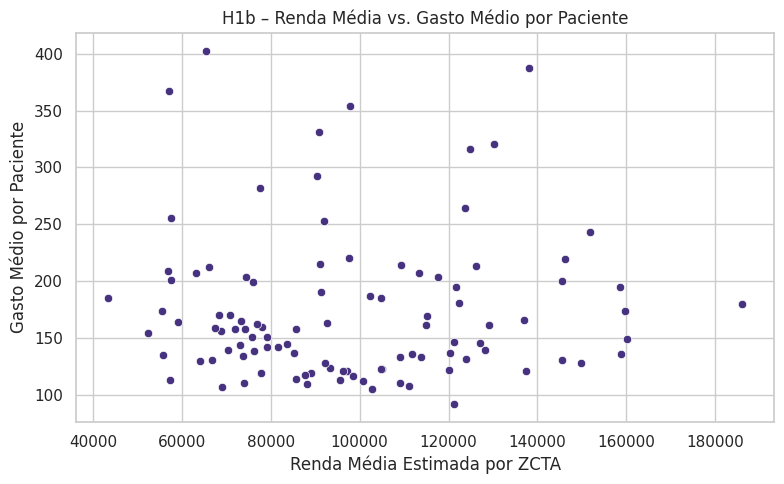

In [15]:
# Agrupa por ZCTA
df_gasto_medio = dfs['transactional'].groupby('ZCTA').agg(
    gasto_total=('Testing Cost', 'sum'),
    num_pacientes=('Patient Id', pd.Series.nunique)
).reset_index()

# Calcula gasto médio por paciente
df_gasto_medio['gasto_medio_paciente'] = df_gasto_medio['gasto_total'] / df_gasto_medio['num_pacientes']

# Adiciona coluna ZCTA na economic
dfs['economic']['ZCTA'] = dfs['economic']['Zipcode'].astype(str).str.zfill(5)

# Dicionário de faixas com colunas e valores médios
faixas_renda = {
    'Households_10k_14k': 12500,
    'Households_15k_24k': 20000,
    'Households_25k_34k': 30000,
    'Households_35k_49k': 42500,
    'Households_50k_74k': 62500,
    'Households_75k_99k': 87500,
    'Households_100k_149k': 125000,
    'Households_150k_199k': 175000,
    'Households_200k_plus': 250000
}

# Soma ponderada
dfs['economic']['soma_ponderada'] = sum(
    dfs['economic'][col] * valor for col, valor in faixas_renda.items()
)

# Total de domicílios nas faixas
dfs['economic']['total_domicilios'] = dfs['economic'][list(faixas_renda.keys())].sum(axis=1)

# Estima renda média
dfs['economic']['renda_media_estimada'] = dfs['economic']['soma_ponderada'] / dfs['economic']['total_domicilios']

df_gasto_medio['ZCTA'] = df_gasto_medio['ZCTA'].astype(str).str.zfill(5)

h1b_df = df_gasto_medio.merge(
    dfs['economic'][['ZCTA', 'renda_media_estimada']],
    on='ZCTA',
    how='inner'
).dropna()

plt.figure(figsize=(8,5))
sns.scatterplot(data=h1b_df, x='renda_media_estimada', y='gasto_medio_paciente')
plt.title('H1b – Renda Média vs. Gasto Médio por Paciente')
plt.xlabel('Renda Média Estimada por ZCTA')
plt.ylabel('Gasto Médio por Paciente')
plt.tight_layout()
plt.show()

### 📊 Conclusões – H1b: Renda Média vs. Gasto Médio por Paciente

- A análise não revelou uma relação linear clara entre a **renda média estimada dos ZCTAs** e o **gasto médio por paciente**.
- A dispersão é grande, e a maioria dos ZCTAs apresenta gastos médios semelhantes, independentemente do nível de renda.
- A presença de outliers com gastos altos não está concentrada nas regiões mais ricas.
- Essa evidência **não apoia a hipótese H1b** de que regiões mais ricas necessariamente gastam mais por paciente.



## 📊 H1c – Proporção de Idosos vs. Volume de Exames

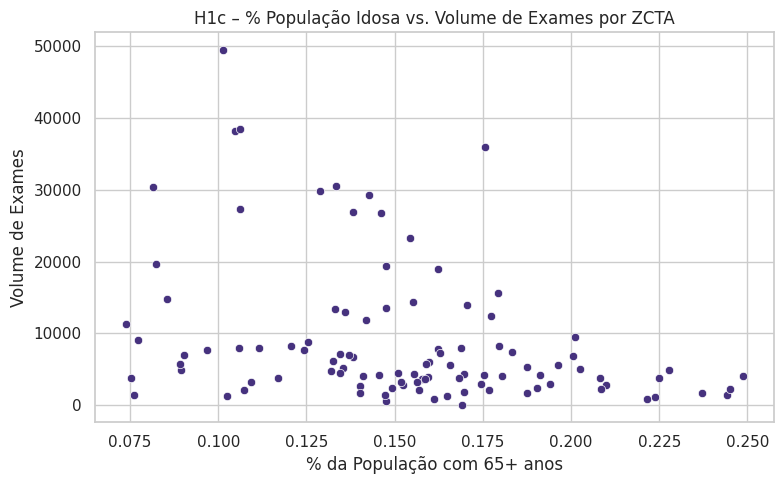

In [16]:
# Garante que ZCTA está presente e padronizado
dfs['demographic']['ZCTA'] = dfs['demographic']['ZCTA'].astype(str).str.zfill(5)
df_exames_por_zcta['ZCTA'] = df_exames_por_zcta['ZCTA'].astype(str).str.zfill(5)

# Calcula % de idosos por ZCTA
dfs['demographic']['perc_idosos'] = (
    dfs['demographic']['Population_65to74Years'] +
    dfs['demographic']['Population_75to84Years'] +
    dfs['demographic']['Population_85YearsAndOver']
) / dfs['demographic']['TotalPopulation']

# Merge com volume de exames
h1c_df = dfs['demographic'].merge(df_exames_por_zcta, on='ZCTA', how='inner')
h1c_df = h1c_df.dropna(subset=['perc_idosos', 'num_exames'])

# Visualização
plt.figure(figsize=(8,5))
sns.scatterplot(data=h1c_df, x='perc_idosos', y='num_exames')
plt.title('H1c – % População Idosa vs. Volume de Exames por ZCTA')
plt.xlabel('% da População com 65+ anos')
plt.ylabel('Volume de Exames')
plt.tight_layout()
plt.show()


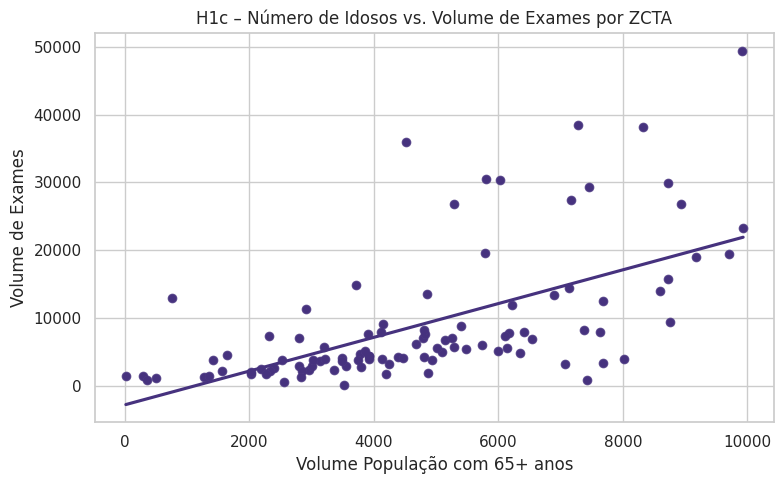

Correlação: 0.60
Correlação: 0.60


In [25]:
dfs['demographic']['num_idosos'] = (
    dfs['demographic']['Population_65to74Years'] +
    dfs['demographic']['Population_75to84Years'] +
    dfs['demographic']['Population_85YearsAndOver']
)

# Merge com volume de exames
h1c_df = dfs['demographic'].merge(df_exames_por_zcta, on='ZCTA', how='inner')
h1c_df = h1c_df.dropna(subset=['num_idosos', 'num_exames'])

# Visualização
plt.figure(figsize=(8,5))
sns.scatterplot(data=h1c_df, x='num_idosos', y='num_exames')
sns.regplot(data=h1c_df, x='num_idosos', y='num_exames', scatter=True, ci=None)
plt.title('H1c – Número de Idosos vs. Volume de Exames por ZCTA')
plt.xlabel('Volume População com 65+ anos')
plt.ylabel('Volume de Exames')
plt.tight_layout()
plt.show()

corr = h1c_df[['num_idosos', 'num_exames']].corr().iloc[0,1]
print(f"Correlação: {corr:.2f}")

In [28]:
from statsmodels.formula.api import ols

# Regressão: num_exames ~ total_pop + num_idosos
reg = ols('num_exames ~ TotalPopulation + num_idosos', data=h1c_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             num_exames   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     56.93
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           3.49e-17
Time:                        16:52:16   Log-Likelihood:                -1042.4
No. Observations:                 102   AIC:                             2091.
Df Residuals:                      99   BIC:                             2099.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2845.8381   1503.934     

### 📊 Regressão múltipla – Interpretação dos coeficientes

Modelo estimado:

\[
\text{num\_exames} = \beta_0 + \beta_1 \cdot \text{TotalPopulation} + \beta_2 \cdot \text{num\_idosos}
\]

| Variável         | Coeficiente | p-valor | Interpretação                                                                 |
|------------------|-------------|---------|--------------------------------------------------------------------------------|
| **TotalPopulation** | +0.416      | **0.000** | Altamente significativa — cada 1.000 habitantes a mais implica ~416 exames extras |
| **num_idosos**      | -0.451      | 0.422   | Não significativa — efeito estatístico desprezível                              |
| **R²**              | 0.535       | —       | O modelo explica aproximadamente 53% da variação no volume de exames           |

> **Conclusão**: ao controlar pela população total, o número de idosos deixa de ser relevante na explicação do volume de exames. Assim, a hipótese H1c não se sustenta de forma isolada.


## 📊 Conclusões – H1c: População Idosa vs. Volume de Exames (com controle)

- A análise inicial sugeriu que ZCTAs com mais idosos realizam mais exames.
- No entanto, ao aplicar uma regressão múltipla controlando pela **população total**, o número de idosos deixou de ser estatisticamente significativo.
- Isso indica que a aparente influência da população idosa no volume de exames **estava mascarada pela população geral** — ou seja, **ZCTAs com mais exames tendem a ter mais pessoas no geral, não necessariamente mais idosos proporcionalmente**.
- Portanto, **a hipótese H1c não é confirmada quando controlamos por população total**.
